# NDIndex Demo

The `NDIndex` is the simplest index for N-D derived coordinates.

**Key concept:**
- Only manages N-D coordinates (like `abs_time` with shape `(trial, rel_time)`)
- Does NOT manage dimension coordinates - they use default xarray indexing
- Enables selection by values in the N-D coordinate

## How NDIndex differs from xarray's NDPointIndex

xarray includes [`NDPointIndex`](https://xarray-indexes.readthedocs.io/blocks/ndpoint.html) for **unstructured point data** (e.g., irregular grids, scattered observations). It uses a KD-tree for spatial nearest-neighbor queries where you search by multiple coordinates simultaneously.

`NDIndex` solves a **different problem**: selecting on **derived coordinates** in structured data.

| Feature | NDPointIndex | NDIndex |
|---------|--------------|---------|
| **Use case** | Unstructured point clouds, curvilinear grids | Structured arrays with derived coordinates |
| **Query type** | Spatial: find nearest (x, y) point | Value: find cell where `abs_time ≈ 7.5` |
| **Data structure** | Points in N-D coordinate space | N-D array of scalar values |
| **Returns** | Single nearest point | Dimensional slices |
| **Supports `isel()`** | No | Yes |
| **Supports slicing** | No | Yes (`abs_time=slice(2, 8)`) |

**Example distinction:**

```python
# NDPointIndex: "Find the grid cell nearest to lat=45.2, lon=-122.5"
ds.sel(lat=45.2, lon=-122.5, method="nearest")  # Spatial query

# NDIndex: "Find which (trial, time) has abs_time closest to 7.5"
ds.sel(abs_time=7.5, method="nearest")  # Value lookup in N-D array
```

NDIndex is ideal for trial-based neuroscience data, time series with multiple reference frames, or any structured data where you have derived N-D coordinates computed from dimension coordinates.

![Diagram showing absolute vs relative time coordinates](images/abs-rel.png.excalidraw.png)

In [63]:
from linked_indices import NDIndex
from linked_indices.example_data import trial_based_dataset

## Create example data

The trial_based_dataset has:
- Dimensions: `(trial, rel_time)`
- 1D coords: `trial`, `rel_time`, `trial_onset`
- 2D coord: `abs_time = trial_onset + rel_time`

In [64]:
ds = trial_based_dataset(mode="stacked")
ds

<xarray.Dataset> Size: 28kB
Dimensions:      (trial: 3, rel_time: 500)
Coordinates:
  * trial        (trial) <U8 96B 'cosine' 'square' 'sawtooth'
  * rel_time     (rel_time) float64 4kB 0.0 0.01 0.02 0.03 ... 4.97 4.98 4.99
    abs_time     (trial, rel_time) float64 12kB 0.0 0.01 0.02 ... 14.98 14.99
    trial_onset  (trial) float64 24B 0.0 5.0 10.0
Data variables:
    data         (trial, rel_time) float64 12kB 1.0 0.9995 0.998 ... -0.02 -0.01

## Apply the NDIndex

Only index the 2D `abs_time` coordinate. The 1D coords keep their default indexes.

In [65]:
ds = ds.set_xindex(["abs_time"], NDIndex)
ds

<xarray.Dataset> Size: 28kB
Dimensions:      (trial: 3, rel_time: 500)
Coordinates:
  * trial        (trial) <U8 96B 'cosine' 'square' 'sawtooth'
  * rel_time     (rel_time) float64 4kB 0.0 0.01 0.02 0.03 ... 4.97 4.98 4.99
  * abs_time     (trial, rel_time) float64 12kB 0.0 0.01 0.02 ... 14.98 14.99
    trial_onset  (trial) float64 24B 0.0 5.0 10.0
Data variables:
    data         (trial, rel_time) float64 12kB 1.0 0.9995 0.998 ... -0.02 -0.01
Indexes:
    abs_time  NDIndex

## Selection by abs_time (2D coord)

When you select `abs_time=7.5`:
- Default: requires exact match in the N-D array
- With `method='nearest'`: finds the cell with value closest to 7.5

The index returns slices for both dimensions that select that cell.

In [66]:
ds.sel(abs_time=7.5)

<xarray.Dataset> Size: 64B
Dimensions:      (trial: 1, rel_time: 1)
Coordinates:
  * trial        (trial) <U8 32B 'square'
  * rel_time     (rel_time) float64 8B 2.5
  * abs_time     (trial, rel_time) float64 8B 7.5
    trial_onset  (trial) float64 8B 5.0
Data variables:
    data         (trial, rel_time) float64 8B 1.0
Indexes:
    abs_time  NDIndex

## Range selection on abs_time

Slice selection finds all cells where the value falls within the range, then returns the **bounding box** in each dimension.

In [5]:
ds.sel(abs_time=slice(2.5, 7.5))

<xarray.Dataset> Size: 20kB
Dimensions:      (trial: 2, rel_time: 500)
Coordinates:
  * trial        (trial) <U8 64B 'cosine' 'square'
  * rel_time     (rel_time) float64 4kB 0.0 0.01 0.02 0.03 ... 4.97 4.98 4.99
  * abs_time     (trial, rel_time) float64 8kB 0.0 0.01 0.02 ... 9.97 9.98 9.99
    trial_onset  (trial) float64 16B 0.0 5.0
Data variables:
    data         (trial, rel_time) float64 8kB 1.0 0.9995 0.998 ... 1.0 1.0 1.0
Indexes:
    abs_time  NDIndex

### ⚠️ Slice selection returns bounding boxes

**Important limitation:** When you use `sel(coord=slice(start, stop))` on an N-D coordinate, NDIndex returns the **bounding box** of all matching cells—not just the cells themselves.

```
                         abs_time values shown in each cell
                         ──────────────────────────────────
                              rel_time: 0    ...    5
                                        ↓           ↓
abs_time array:          ┌─────────────────────────────┐
       trial 0 (cosine)  │ 0.0   0.1   ...   4.9   5.0 │  (abs_time = 0 + rel_time)
       trial 1 (square)  │ 5.0   5.1   ...   9.9  10.0 │  (abs_time = 5 + rel_time)
       trial 2 (sawtooth)│10.0  10.1   ...  14.9  15.0 │  (abs_time = 10 + rel_time)
                         └─────────────────────────────┘

Matching cells             Result (bounding box)
for abs_time 2.5-7.5:      ─────────────────────
                         ┌─────────────────────────────┐
       trial 0 (cosine)  │      ░░░░░░░░░░░░░░░░░░░░░░ │  ← only right half matches
       trial 1 (square)  │ ░░░░░░░░░░░░░                │  ← only left half matches  
       trial 2 (sawtooth)│                              │  ← no match, EXCLUDED
                         └─────────────────────────────┘
                               ↑                   ↑
                         But result includes ALL rel_time (0 to 5)
                         because that's the bounding box!
```

The slice `abs_time=slice(2.5, 7.5)` matches:
- **cosine**: rel_time 2.5–5.0 (where abs_time is 2.5–5.0)
- **square**: rel_time 0.0–2.5 (where abs_time is 5.0–7.5)

The bounding box is the **union** of these ranges:
- **trial**: indices 0–1 (both have matches)
- **rel_time**: indices covering 0.0–5.0 (union of [2.5, 5.0] and [0.0, 2.5])

So the result includes **all** rel_time values, even though each trial only partially matches!

**Why?** xarray's indexing requires rectangular slices. There's no way to return "cosine for rel_time > 2.5, square for rel_time < 2.5".

**Workaround:** Select the bounding box first, then mask:

```python
result = ds.sel(abs_time=slice(2.5, 7.5))
mask = (result.abs_time >= 2.5) & (result.abs_time <= 7.5)
filtered = result.where(mask)
```

In [6]:
# Demonstrate bounding box behavior
# Create a fresh dataset for clarity
demo_ds = trial_based_dataset(mode="stacked")
demo_ds = demo_ds.set_xindex(["abs_time"], NDIndex)

print("Dataset structure:")
print(f"  Trials: {list(demo_ds.trial.values)}")
print(f"  Trial onsets: {list(demo_ds.trial_onset.values)}")
print("  Each trial spans rel_time 0.0 to 4.99")
print()
print("abs_time ranges per trial:")
for trial in demo_ds.trial.values:
    t = demo_ds.sel(trial=trial)
    print(
        f"  {trial}: abs_time {float(t.abs_time.min()):.1f} to {float(t.abs_time.max()):.1f}"
    )

Dataset structure:
  Trials: [np.str_('cosine'), np.str_('square'), np.str_('sawtooth')]
  Trial onsets: [np.float64(0.0), np.float64(5.0), np.float64(10.0)]
  Each trial spans rel_time 0.0 to 4.99

abs_time ranges per trial:
  cosine: abs_time 0.0 to 5.0
  square: abs_time 5.0 to 10.0
  sawtooth: abs_time 10.0 to 15.0


In [7]:
# Select abs_time from 2.5 to 7.5
# This should match:
#   - cosine trial: rel_time 2.5-4.99 (abs_time 2.5-4.99)
#   - square trial: rel_time 0.0-2.5 (abs_time 5.0-7.5)
#   - sawtooth trial: NO MATCH (abs_time 10.0-14.99)

result = demo_ds.sel(abs_time=slice(2.5, 7.5))

print("Result of sel(abs_time=slice(2.5, 7.5)):")
print(f"  Trials included: {list(result.trial.values)}")
print(
    f"  rel_time range: {float(result.rel_time.min()):.2f} to {float(result.rel_time.max()):.2f}"
)
print(f"  Result shape: {dict(result.sizes)}")
print()
print("But the ACTUAL abs_time values in result span:")
print(f"  min: {float(result.abs_time.min()):.2f}")
print(f"  max: {float(result.abs_time.max()):.2f}")
print()
print("This includes values OUTSIDE our requested range [2.5, 7.5]!")

Result of sel(abs_time=slice(2.5, 7.5)):
  Trials included: [np.str_('cosine'), np.str_('square')]
  rel_time range: 0.00 to 4.99
  Result shape: {'trial': 2, 'rel_time': 500}

But the ACTUAL abs_time values in result span:
  min: 0.00
  max: 9.99

This includes values OUTSIDE our requested range [2.5, 7.5]!


In [8]:
# Show which cells are OUTSIDE the requested range
outside_range = (result.abs_time < 2.5) | (result.abs_time > 7.5)
n_outside = int(outside_range.sum())
n_total = result.abs_time.size

print(
    f"Cells outside requested range [2.5, 7.5]: {n_outside} / {n_total} ({100 * n_outside / n_total:.1f}%)"
)
print()
print("Per trial breakdown:")
for trial in result.trial.values:
    trial_data = result.sel(trial=trial)
    in_range = (trial_data.abs_time >= 2.5) & (trial_data.abs_time <= 7.5)
    print(
        f"  {trial}: {int(in_range.sum())} in range, {int((~in_range).sum())} outside range"
    )

Cells outside requested range [2.5, 7.5]: 499 / 1000 (49.9%)

Per trial breakdown:
  cosine: 250 in range, 250 outside range
  square: 251 in range, 249 outside range


In [9]:
# Workaround: use .where() to mask values outside the range
mask = (result.abs_time >= 2.5) & (result.abs_time <= 7.5)
filtered = result.where(mask)

print("After applying .where() mask:")
print(f"  Shape unchanged: {dict(filtered.sizes)}")
print("  But values outside range are now NaN")
print()
# Show the data values - NaN where outside range
print("Sample of filtered data (showing NaN for out-of-range cells):")
print(filtered.data.values[:, :5])  # First 5 time points

After applying .where() mask:
  Shape unchanged: {'trial': 2, 'rel_time': 500}
  But values outside range are now NaN

Sample of filtered data (showing NaN for out-of-range cells):
[[nan nan nan nan nan]
 [ 1.  1.  1.  1.  1.]]


### Slice methods

You can configure how NDIndex handles slice selection using the `slice_method` option:

| Method | Description |
|--------|-------------|
| `"bounding_box"` (default) | Returns the smallest rectangular region containing all matching cells |
| `"trim_outer"` | Like bounding_box, but more aggressively trims outer dimension indices |

```python
# Default: bounding_box
ds.set_xindex(["abs_time"], NDIndex)

# Alternative: trim_outer
ds.set_xindex(["abs_time"], NDIndex, slice_method="trim_outer")
```

The `slice_method` is preserved through `isel()` operations.

### Slice with step

You can include a step in your slice selection. The step is applied to the **innermost dimension** (typically `rel_time` or similar):

```python
# Select every 2nd point in the abs_time range 0-5
ds.sel(abs_time=slice(0, 5, 2))
```

This first finds the bounding box for `abs_time` in [0, 5], then applies `step=2` to the inner dimension slice.

**Example:** If the inner dimension normally covers indices 0-50, a step of 2 gives indices 0, 2, 4, ..., 48, 50—roughly half the points.

In [10]:
# Demonstrate slice with step
# Original data has 500 time points
print(f"Original rel_time size: {ds.sizes['rel_time']}")

# Select abs_time 0-3 with step=5 (every 5th point)
result = ds.sel(abs_time=slice(0, 3, 5))
print(f"After slice(0, 3, 5) rel_time size: {result.sizes['rel_time']}")
print(
    f"Rel_time spacing: {result.rel_time.values[1] - result.rel_time.values[0]:.2f}s (5× original)"
)

Original rel_time size: 500
After slice(0, 3, 5) rel_time size: 61
Rel_time spacing: 0.05s (5× original)


## Selection by trial (1D coord, default xarray index)

The `trial` coord uses xarray's default PandasIndex - our NDIndex doesn't interfere.

In [11]:
ds.sel(trial="square")

<xarray.Dataset> Size: 12kB
Dimensions:      (rel_time: 500)
Coordinates:
  * rel_time     (rel_time) float64 4kB 0.0 0.01 0.02 0.03 ... 4.97 4.98 4.99
    trial        <U8 32B 'square'
    abs_time     (rel_time) float64 4kB 5.0 5.01 5.02 5.03 ... 9.97 9.98 9.99
    trial_onset  float64 8B 5.0
Data variables:
    data         (rel_time) float64 4kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

## Selection by rel_time (1D coord, default xarray index)

In [12]:
ds.sel(rel_time=2.5, method="nearest")

<xarray.Dataset> Size: 176B
Dimensions:      (trial: 3)
Coordinates:
  * trial        (trial) <U8 96B 'cosine' 'square' 'sawtooth'
    rel_time     float64 8B 2.5
    abs_time     (trial) float64 24B 2.5 7.5 12.5
    trial_onset  (trial) float64 24B 0.0 5.0 10.0
Data variables:
    data         (trial) float64 24B 3.062e-16 1.0 -0.5

## isel works correctly

Integer selection with scalars properly drops dimensions.

In [13]:
ds.isel(trial=1)

<xarray.Dataset> Size: 12kB
Dimensions:      (rel_time: 500)
Coordinates:
  * rel_time     (rel_time) float64 4kB 0.0 0.01 0.02 0.03 ... 4.97 4.98 4.99
    trial        <U8 32B 'square'
    abs_time     (rel_time) float64 4kB 5.0 5.01 5.02 5.03 ... 9.97 9.98 9.99
    trial_onset  float64 8B 5.0
Data variables:
    data         (rel_time) float64 4kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

## Plotting works correctly

The original bug was that plotting drew too many lines. With NDIndex, plotting works as expected.

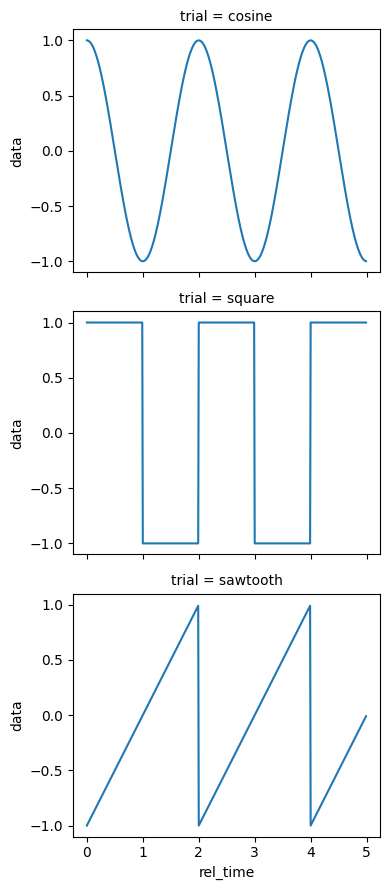

In [14]:
ds["data"].plot.line(x="rel_time", row="trial")

## Time-Locking to Events

A key use case for NDIndex is **time-locking**: aligning data to events that occur at different times in each trial. For example, in neuroscience you might want to analyze neural activity relative to:
- Stimulus onset (when the stimulus appeared)
- Speech onset (when the subject started speaking)
- Response time (when they pressed a button)

Each of these events happens at a different time in each trial, creating a 2D time coordinate.

![Diagram showing event-locking concept](images/event-locking.png.excalidraw.png)

In [15]:
# Add event times that vary per trial
ds = ds.assign_coords(
    {
        "stim_onset": ("trial", [0.5, 0.3, 0.4]),  # When stimulus appeared
        "speech_onset": ("trial", [1.5, 2.5, 3.0]),  # When subject started speaking
        "response_time": ("trial", [2.0, 1.8, 2.2]),  # When they pressed button
    }
)

# Create time-locked coordinates (2D: trial × rel_time)
# These measure time relative to each event
ds = ds.assign_coords(
    {
        "stim_locked": ds["rel_time"] - ds["stim_onset"],
        "speech_locked": ds["rel_time"] - ds["speech_onset"],
        "response_locked": ds["rel_time"] - ds["response_time"],
    }
)

# Add the time-locked coords to the NDIndex for selection
ds = ds.drop_indexes("abs_time").set_xindex(
    ["abs_time", "stim_locked", "speech_locked", "response_locked"], NDIndex
)
ds

<xarray.Dataset> Size: 64kB
Dimensions:          (trial: 3, rel_time: 500)
Coordinates:
  * trial            (trial) <U8 96B 'cosine' 'square' 'sawtooth'
  * rel_time         (rel_time) float64 4kB 0.0 0.01 0.02 ... 4.97 4.98 4.99
    trial_onset      (trial) float64 24B 0.0 5.0 10.0
    stim_onset       (trial) float64 24B 0.5 0.3 0.4
    speech_onset     (trial) float64 24B 1.5 2.5 3.0
    response_time    (trial) float64 24B 2.0 1.8 2.2
  * abs_time         (trial, rel_time) float64 12kB 0.0 0.01 ... 14.98 14.99
  * stim_locked      (rel_time, trial) float64 12kB -0.5 -0.3 -0.4 ... 4.69 4.59
  * speech_locked    (rel_time, trial) float64 12kB -1.5 -2.5 -3.0 ... 2.49 1.99
  * response_locked  (rel_time, trial) float64 12kB -2.0 -1.8 -2.2 ... 3.19 2.79
Data variables:
    data             (trial, rel_time) float64 12kB 1.0 0.9995 ... -0.02 -0.01
Indexes:
  ┌ abs_time         NDIndex
  │ stim_locked
  │ speech_locked
  └ response_locked

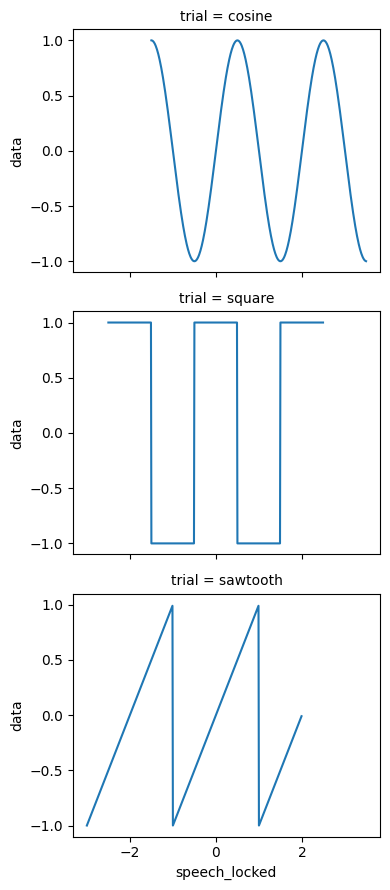

In [16]:
# Plot aligned to speech onset - time=0 is when subject started speaking
ds["data"].plot.line(x="speech_locked", row="trial");

### Select by time-locked coordinate

Now we can select data relative to events. For example, get the data point closest to 0.5 seconds after speech onset:

In [17]:
# Select 0.5 seconds after speech onset (in each trial)
ds.sel(speech_locked=0.5, method="nearest")

<xarray.Dataset> Size: 112B
Dimensions:          (trial: 1, rel_time: 1)
Coordinates:
  * trial            (trial) <U8 32B 'cosine'
  * rel_time         (rel_time) float64 8B 2.0
    trial_onset      (trial) float64 8B 0.0
    stim_onset       (trial) float64 8B 0.5
    speech_onset     (trial) float64 8B 1.5
    response_time    (trial) float64 8B 2.0
  * abs_time         (trial, rel_time) float64 8B 2.0
  * stim_locked      (rel_time, trial) float64 8B 1.5
  * speech_locked    (rel_time, trial) float64 8B 0.5
  * response_locked  (rel_time, trial) float64 8B 0.0
Data variables:
    data             (trial, rel_time) float64 8B 1.0
Indexes:
  ┌ abs_time         NDIndex
  │ stim_locked
  │ speech_locked
  └ response_locked

### Select a time window around an event

Get data from 0.5 seconds before to 1.0 seconds after stimulus onset:

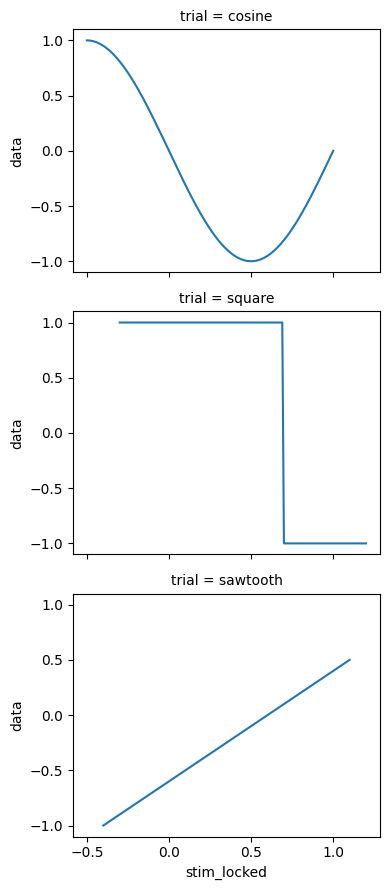

In [18]:
# Select -0.5 to +1.0 seconds around stimulus onset
window = ds.sel(stim_locked=slice(-0.5, 1.0))
window["data"].plot.line(x="stim_locked", row="trial");

### Compare different alignments

The same data looks different when aligned to different events. Here we compare stimulus-locked vs response-locked views:

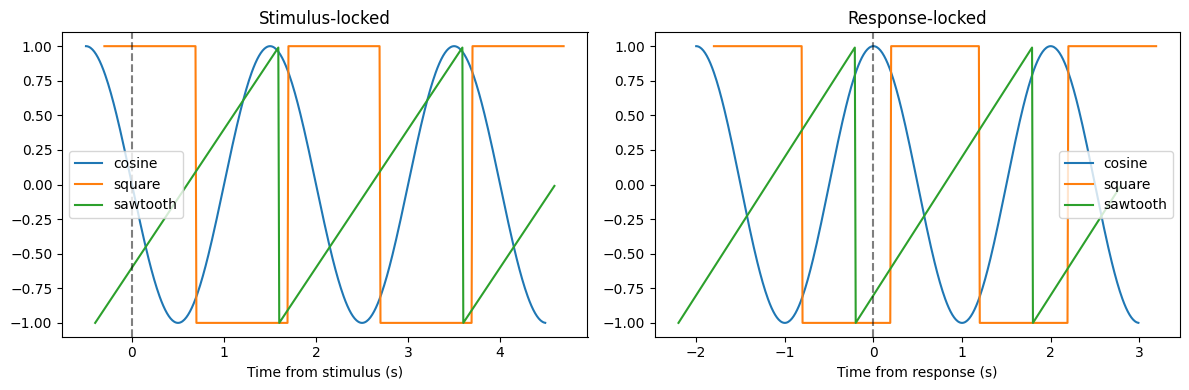

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: stimulus-locked
for i, trial in enumerate(ds.trial.values):
    trial_data = ds.sel(trial=trial)
    axes[0].plot(trial_data.stim_locked, trial_data.data, label=trial)
axes[0].axvline(0, color="k", linestyle="--", alpha=0.5)
axes[0].set_xlabel("Time from stimulus (s)")
axes[0].set_title("Stimulus-locked")
axes[0].legend()

# Right: response-locked
for i, trial in enumerate(ds.trial.values):
    trial_data = ds.sel(trial=trial)
    axes[1].plot(trial_data.response_locked, trial_data.data, label=trial)
axes[1].axvline(0, color="k", linestyle="--", alpha=0.5)
axes[1].set_xlabel("Time from response (s)")
axes[1].set_title("Response-locked")
axes[1].legend()

plt.tight_layout();

## 3D Coordinates: Multi-Subject Data

NDIndex works with coordinates of any dimensionality ≥2. Here's an example with **3D absolute time** across subjects, trials, and time points.

In multi-subject studies, each subject's session starts at a different real-world time. The 3D `abs_time` coordinate captures this:

In [20]:
import numpy as np
import xarray as xr

# Create 3D dataset: 2 subjects × 3 trials × 50 time points
n_subjects, n_trials, n_times = 2, 3, 50

subjects = ["alice", "bob"]
trials = ["trial_0", "trial_1", "trial_2"]
rel_time = np.linspace(0, 1, n_times)

# Each subject's session started at a different time (e.g., different days)
subject_offset = xr.DataArray(
    [0.0, 1000.0], dims=["subject"], coords={"subject": subjects}
)

# Trial onsets within each session
trial_onset = xr.DataArray([0.0, 2.0, 4.0], dims=["trial"], coords={"trial": trials})

# 3D absolute time = subject_offset + trial_onset + rel_time
# Shape: (subject, trial, rel_time) = (2, 3, 50)
abs_time_3d = subject_offset + trial_onset + xr.DataArray(rel_time, dims=["rel_time"])

# Create dataset with random signal data
ds_3d = xr.Dataset(
    {
        "signal": (
            ("subject", "trial", "rel_time"),
            np.random.randn(n_subjects, n_trials, n_times),
        )
    },
    coords={
        "subject": subjects,
        "trial": trials,
        "rel_time": rel_time,
        "abs_time": abs_time_3d,
    },
)

# Apply NDIndex to the 3D coordinate
ds_3d = ds_3d.set_xindex(["abs_time"], NDIndex)
ds_3d

<xarray.Dataset> Size: 5kB
Dimensions:   (subject: 2, trial: 3, rel_time: 50)
Coordinates:
  * subject   (subject) <U5 40B 'alice' 'bob'
  * trial     (trial) <U7 84B 'trial_0' 'trial_1' 'trial_2'
  * rel_time  (rel_time) float64 400B 0.0 0.02041 0.04082 ... 0.9592 0.9796 1.0
  * abs_time  (subject, trial, rel_time) float64 2kB 0.0 0.02041 ... 1.005e+03
Data variables:
    signal    (subject, trial, rel_time) float64 2kB 0.4967 -0.1383 ... 0.6296
Indexes:
    abs_time  NDIndex

The `abs_time` coordinate now has shape `(subject, trial, rel_time)`:

```
Alice's session (offset=0):        Bob's session (offset=1000):
Trial 0: 0.0 → 1.0                 Trial 0: 1000.0 → 1001.0
Trial 1: 2.0 → 3.0                 Trial 1: 1002.0 → 1003.0  
Trial 2: 4.0 → 5.0                 Trial 2: 1004.0 → 1005.0
```

### Selection on 3D coordinates

In [21]:
# Find the cell where abs_time ≈ 1002.5 (Bob's session, trial 1, middle)
result = ds_3d.sel(abs_time=1002.5, method="nearest")
print(f"Subject: {result.subject.item()}")
print(f"Trial: {result.trial.item()}")
print(f"Rel_time: {result.rel_time.item():.2f}")
print(f"Abs_time: {result.abs_time.item():.2f}")
result

Subject: bob
Trial: trial_1
Rel_time: 0.49
Abs_time: 1002.49


<xarray.Dataset> Size: 72B
Dimensions:   (subject: 1, trial: 1, rel_time: 1)
Coordinates:
  * subject   (subject) <U5 20B 'bob'
  * trial     (trial) <U7 28B 'trial_1'
  * rel_time  (rel_time) float64 8B 0.4898
  * abs_time  (subject, trial, rel_time) float64 8B 1.002e+03
Data variables:
    signal    (subject, trial, rel_time) float64 8B -0.4719
Indexes:
    abs_time  NDIndex

### Dimension reduction with 3D coords

When you use `isel()` with scalar indexers, dimensions are dropped and the N-D coordinate reduces accordingly:

In [22]:
# Select one subject: 3D → 2D (NDIndex stays active)
alice = ds_3d.isel(subject=0)
print(f"After isel(subject=0): abs_time.dims = {alice.abs_time.dims}")
print(f"NDIndex still active: {'abs_time' in alice.xindexes}")

# Select one subject AND one trial: 3D → 1D (NDIndex dropped)
single_trial = ds_3d.isel(subject=0, trial=1)
print(f"\nAfter isel(subject=0, trial=1): abs_time.dims = {single_trial.abs_time.dims}")
print(f"NDIndex dropped (1D coord): {'abs_time' not in single_trial.xindexes}")

After isel(subject=0): abs_time.dims = ('trial', 'rel_time')
NDIndex still active: True

After isel(subject=0, trial=1): abs_time.dims = ('rel_time',)
NDIndex dropped (1D coord): True


## Summary

The `NDIndex` enables powerful operations on N-D derived coordinates:

**Basic features:**
- Manages N-D coordinates (2D, 3D, or higher)
- Enables `sel()` on those coordinates to find matching indices
- Lets 1D dimension coordinates use default xarray indexing
- Properly handles `isel()` with dimension dropping
- Works correctly with plotting

**Slice selection options:**
- `slice_method="bounding_box"` (default): smallest rectangle containing all matches
- `slice_method="trim_outer"`: like bounding_box but trims outer dimensions more aggressively
- Step support: `sel(coord=slice(start, stop, step))` applies step to innermost dimension

**Time-locking workflow:**
1. Add event times as 1D coordinates (per trial)
2. Create time-locked coordinates: `rel_time - event_onset`
3. Add them to NDIndex: `set_xindex([...], NDIndex)`
4. Select and plot relative to any event

**Limitations:**
- Slice selection returns **bounding boxes**, not exact matches
- Use `.where()` for precise filtering after slice selection

This makes it easy to analyze the same data from multiple temporal perspectives—a common need in neuroscience, psychophysics, and other time-series domains.